# Emoji Hunt Challenge - ML Method

## Google collab pre-requisites

In [ ]:
!pip install wandb
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
model_file = '/content/gdrive/MyDrive/emoji_hunt_model.h5'

## Implementation

In [4]:
import wandb
from wandb.keras import WandbCallback
from emojihunt import *
import tensorflow as tf
import keras
from keras import callbacks
from keras.models import Sequential, load_model
from keras.layers import Activation, LeakyReLU, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate, UpSampling2D, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import Sequence
import json
import os
from skimage.segmentation import slic, mark_boundaries, clear_border, find_boundaries
from skimage.morphology import binary_dilation
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans


gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs: 0


Basic hyperparameters

In [5]:
lr = 0.0001
downsample_f = 2
img_width = img_height = 512 // downsample_f
batch_size = downsample_f * 4

if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


Create our own emojihunt object that returns a segmentation mask with each image

In [6]:
class SegEmojiHunt(EmojiHunt):
    def generate_image_and_points(self):
        '''
        Returns a target image, emoji example (uncorrupted), and ground truth gt_points. For your testing and development
        '''
        # Seed the random number generator to be very random
        random.seed()
        emoji_target = self.get_random_emoji_img()
        test_image   = self.get_background()

        gt_points = []
        mask = np.zeros(test_image.shape[:-1], dtype=np.uint8)
        tmp_mask = np.zeros_like(mask)
        for _ in range(random.randint(1,10)):
            x = random.randint(0,512-self.emoji_size-1)
            y = random.randint(0,512-self.emoji_size-1)
            gt_points.append((x+self.emoji_size//downsample_f,y+self.emoji_size//downsample_f))
            augmented_emoji = self.augment_emoji(emoji_target)
            emoji_mask = np.sum(augmented_emoji,axis=-1) > 25
            
            # Compare the intersection of the new mask and the previous mask. If there's any overlap then we trace a line of zeros around the edge of the intersection
            tmp_mask[:,:] = 0
            # tmp_mask[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
            #         np.sum(augmented_emoji,axis=-1) > 25, emoji_mask, mask[x:x+self.emoji_size,y:y+self.emoji_size])
            tmp_mask[x:x+self.emoji_size,y:y+self.emoji_size] = emoji_mask
            intersection = np.logical_and(tmp_mask, mask)
            if np.any(intersection):
                mask[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                    np.sum(augmented_emoji,axis=-1) > 25, emoji_mask, mask[x:x+self.emoji_size,y:y+self.emoji_size])
   
                # Find the contour of the intersection
                contour = find_boundaries(tmp_mask, mode='thick')
                # Expand the contour by 1 pixel
                # contour = binary_dilation(contour)
                
                # Trace a line of zeros around the contour
                mask[contour] = 0

            else:
                mask[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                    np.sum(augmented_emoji,axis=-1) > 25, emoji_mask, mask[x:x+self.emoji_size,y:y+self.emoji_size])
            
            test_image[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                np.expand_dims(np.sum(augmented_emoji,axis=-1) > 25,-1), augmented_emoji, test_image[x:x+self.emoji_size,y:y+self.emoji_size])
        
        test_image_agus = [iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
                            iaa.GaussianBlur(sigma=(0.0, 0.25))]

        test_image = iaa.Sequential(test_image_agus)(image=test_image)

        return test_image, emoji_target, gt_points, mask

Data Generator to feed the model. Resizes the input image, converts it to LAB, and normalizes it to [-1, 1]

In [7]:
class DataGenerator(keras.utils.Sequence):
    emoji_hunt_object = SegEmojiHunt()

    def __init__(self, batch_size, augment, num_batches=100):
        self.batch_size = batch_size
        self.augment = augment
        self.num_batches = num_batches
        self.datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

    def __len__(self):
        return batch_size*self.num_batches

    def __getitem__(self, idx):
        'Generate one batch of data'
        X = np.empty((self.batch_size, *input_shape), dtype=np.uint8)
        Y = np.zeros((self.batch_size, img_width, img_height), dtype=np.uint8)
        C = np.zeros_like(Y)
        for i in range(self.batch_size):
            target_image, emoji, ground_truth, mask = self.emoji_hunt_object.generate_image_and_points()
            # Convert to RGB and resize
            target_image = cv2.resize(target_image, (img_width, img_height), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask.astype('uint8'), (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2LAB)

            # Insert centroids
            # Select all pixels touching the centroid too
            # for x,y in ground_truth:
            #     C[i,x//downsample_f,y//downsample_f] = 1
            #     C[i,x//downsample_f-1,y//downsample_f] = 1
            #     C[i,x//downsample_f+1,y//downsample_f] = 1
            #     C[i,x//downsample_f,y//downsample_f-1] = 1
            #     C[i,x//downsample_f,y//downsample_f+1] = 1
            #     C[i,x//downsample_f-1,y//downsample_f-1] = 1
            #     C[i,x//downsample_f+1,y//downsample_f+1] = 1
            #     C[i,x//downsample_f-1,y//downsample_f+1] = 1
            #     C[i,x//downsample_f+1,y//downsample_f-1] = 1


            X[i,] = target_image
            Y[i] = mask

        # Normalize
        self.datagen.standardize(X)
        assert img_width == img_height
        
        return X, {'segmentation': Y}
        # return X, {'segmentation': Y, 'centroids': C}

169001437/169001437 [==============================] - 2s 0us/step


Generate some example masks

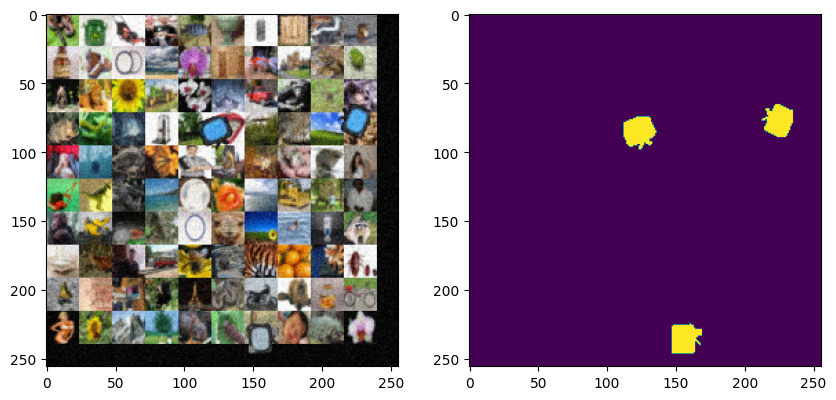

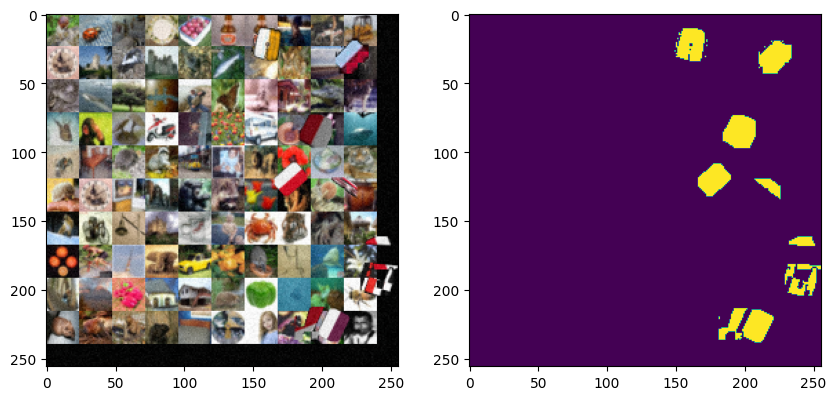

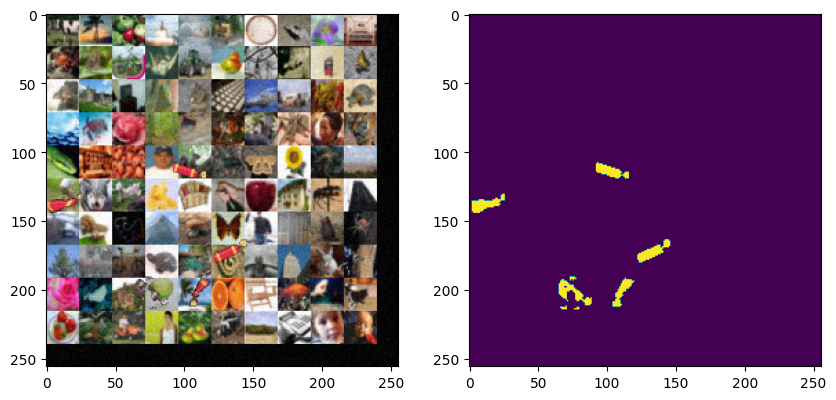

In [8]:
train_ds = DataGenerator(batch_size, augment=False, num_batches=1200//batch_size)
val_ds = DataGenerator(batch_size, augment=False, num_batches=20) # Only used for scoring, generates the same data as train but with a smaller batch size

batch = train_ds[0]
for i in range(3):
    plt.figure(figsize=(10,10))
    # show color scale
    ax = plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(batch[0][i], cv2.COLOR_LAB2RGB))
    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    plt.imshow(batch[1]['segmentation'][i])
    # plt.imshow(batch[1]['centroids'][i], alpha=0.5)
    plt.show()

Setup for weights and biases logging (optional)

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="emoji-hunt",

    # track hyperparameters and run metadata with wandb.config
    config={
        "batch_size": batch_size
    }
)

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/ for the U-Net architecture

In [10]:
def double_conv_block(x, n_filters):
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D()(f)
   p = Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = Concatenate(axis=-1)([x, conv_features])
   x = Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [19]:
# From https://stackoverflow.com/questions/68481772/why-my-iou-keep-decrease-in-training-with-tensorflow-keras
def iou(y_true, y_pred):
    y_true = keras.backend.flatten(y_true)
    y_pred = keras.backend.flatten(tf.argmax(y_pred, -1))
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    union = keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def iou_loss(y_true, y_pred):
        return 1.0 - iou(y_true, y_pred)

if os.path.exists(model_file):
    print(f'Loading model from file: {model_file}')
    model = load_model(model_file)
else:
    in1 = keras.Input(shape=input_shape)

    # encoder: contracting path - downsample
    f1, p1 = downsample_block(in1, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    # outputs
    # c1 = double_conv_block(u9, 128)
    # c2 = double_conv_block(c1, 128)
    # output_centroids = Conv2D(2, 1, padding="same", activation = "softmax", name='centroids')(c2)
    output_mask = Conv2D(2, 1, padding="same", activation="softmax", name='segmentation')(u9)


    model = keras.Model(in1, {"segmentation": output_mask}, name="U-Net")

    model.compile(loss={"segmentation": 'sparse_categorical_crossentropy'},
                optimizer=Adam(learning_rate=lr),
                metrics={"segmentation": ['accuracy', iou]})

    #model = keras.Model(in1, {"segmentation": output_mask, "centroids": output_centroids}, name="U-Net")
    # model.compile(loss={"segmentation": 'sparse_categorical_crossentropy', "centroids": 'sparse_categorical_crossentropy'},
    #               # Loss weight
    #             loss_weights={"segmentation": 0.5, "centroids": 1.0},
    #             optimizer=Adam(learning_rate=lr),
    #             metrics={"segmentation": ['accuracy', iou], "centroids": iou})
    
    keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, to_file='model.png', show_layer_names=False)
    model.summary()

Loading model from file: /content/gdrive/MyDrive/emoji_hunt_model.h5


In [ ]:
# early_stopping = callbacks.EarlyStopping(monitor='iou', mode='max', patience=4, restore_best_weights=True, start_from_epoch=5)
# tensorboard = callbacks.TensorBoard(log_dir=f'./logs/run{np.random.randint(1,1000)}', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=5)
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='iou', mode='max', factor=0.2, patience=1, min_lr=0.000001, min_delta=0.0003)
# checkpoint = callbacks.ModelCheckpoint(f'./model.h5', monitor='iou', mode='max', verbose=0, save_best_only=True, save_weights_only=False, save_freq='epoch')
# model.fit(train_ds,
#         batch_size=batch_size,
#         epochs=20,
#         callbacks=[early_stopping, reduce_lr, checkpoint, WandbCallback(input_type="image", output_type="segmentation_mask", log_weights=True, save_model=True)],
#         # callbacks=[early_stopping, reduce_lr, checkpoint],
#         use_multiprocessing=True,
#         workers=90)
# wandb.save('model.h5')

## Results
**256x256:**  
Unet mask -> remove small clusters under 20 = ~50 score  
Unet mask with 0s between touching emojis -> remove small clusters under 20 = ~41  
Unet remove all intersecting emoji areas -> remove small clusters under 50 = ~49 iou 0.86

**512x512:**  
Unet mask with 0s between touching emojis -> remove small clusters under 100 = ~240 iou 0.93

**128x128:**  
Unet mask with 0s between touching emojis -> remove small clusters under 20 = ~212 iou 0.81

In [45]:
def centroids_from_mask(pred_mask):
    # Create regions from the segmentation mask
    ret_coords = []
    segments = [region for region in regionprops(label(pred_mask)) if region.area > 45]
    
    # Good stats
    mean_area = np.mean([region.area for region in segments])
    median_area = np.median([region.area for region in segments])
    mean_perimeter = np.mean([region.perimeter for region in segments])
    median_perimeter = np.median([region.perimeter for region in segments])
    std_area = np.std([region.area for region in segments])
    std_perimeter = np.std([region.perimeter for region in segments])
    
    # Find possible cluster elements that are otherwise too small
    possible_clusters = [region for region in segments if region.area < median_area]
    for c in possible_clusters:
        segments.remove(c)

    # Find possible touching regions that should be seperate (usually they're just too big)
    possible_touching = [region for region in segments if region.area > mean_area + std_area*2 or region.perimeter > median_perimeter + (std_perimeter*2)]
    for c in possible_touching:
        segments.remove(c)

    confirmed_centroids = [props.centroid for props in segments]

    # Merge nearby clusters
    while len(possible_clusters) > 0:
        region = possible_clusters[0]
        nearby_clusters = [region2 for region2 in possible_clusters if np.linalg.norm(np.array(region.centroid) - np.array(region2.centroid)) < 20]
        if len(nearby_clusters) > 0:
            # Merge nearby clusters
            new_centroid = np.mean([region.centroid for region in nearby_clusters], axis=0)
            confirmed_centroids.append(new_centroid)
            for cluster in nearby_clusters:
                possible_clusters.remove(cluster)
        else:
            # Nothing nearby, so it's a new cluster
            confirmed_centroids.append(region.centroid)
            possible_clusters.remove(region)

    # Seperate big regions
    while len(possible_touching) > 0:
        region = possible_touching[0]
        
        cluster_centroids = KMeans(n_clusters=2, n_init='auto').fit(region.coords).cluster_centers_
        for centroid in cluster_centroids:
            confirmed_centroids.append(centroid)

        possible_touching.remove(region)


    ret_coords = [(int(cx*downsample_f), int(cy*downsample_f)) for cx, cy in confirmed_centroids] 
    return ret_coords

## Some Visualizations

1/1 [==============================] - 11s 11s/step


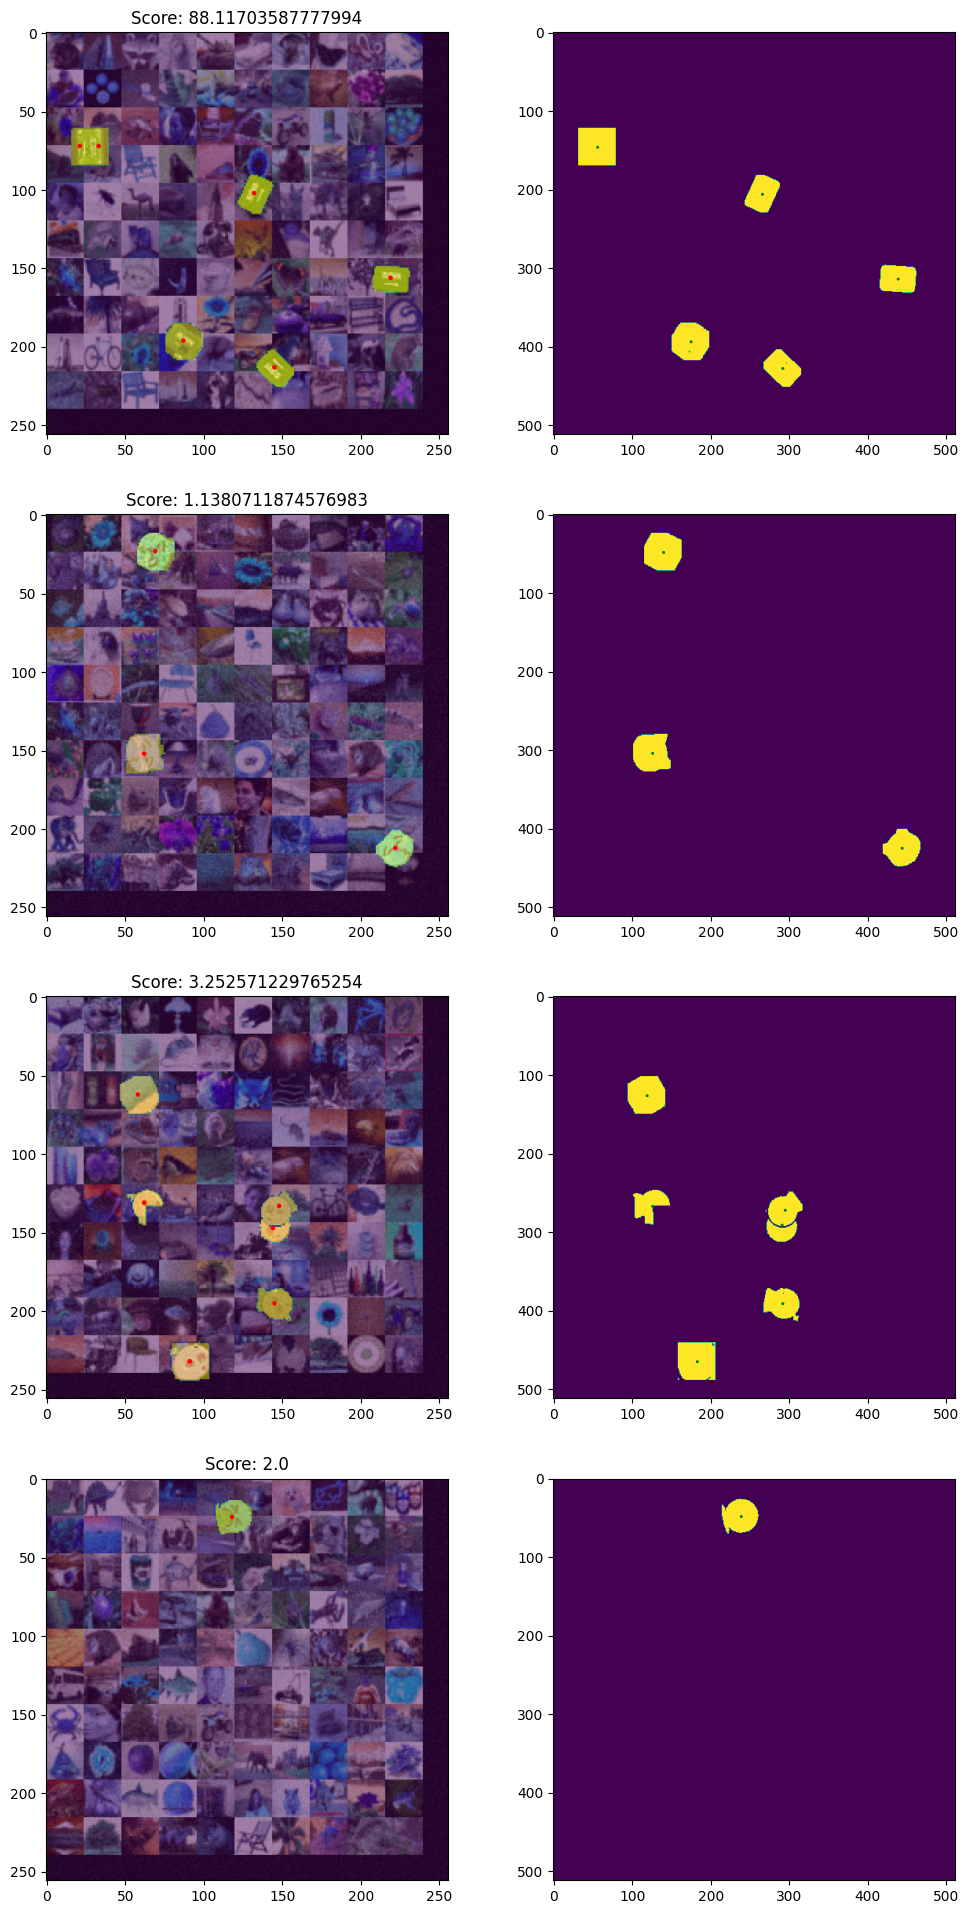

In [47]:
emoji_hunt_object = EmojiHunt() 
samples = [val_ds.emoji_hunt_object.generate_image_and_points() for _ in range(batch_size)]

sample_imgs = [sample[0] for sample in samples]
sample_emojis = [sample[1] for sample in samples]
sample_ground_truth = [sample[2] for sample in samples]
sample_emoji_mask = [sample[3] for sample in samples]

inputs = np.empty((batch_size, *input_shape))
for i, image in enumerate(sample_imgs):
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    sample_imgs[i] = image # For displaying in human-viewable form
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    val_ds.datagen.standardize(image)
    inputs[i] = image

preds = model.predict(inputs, batch_size=batch_size)
pred_masks = np.argmax(preds, axis=-1)

# Plot 4 results, print the image and mask seperately
fig, axs = plt.subplots(4, 2, figsize=(12, 24))
i = 0
for img, mask, ground_truth, gt_mask in zip(sample_imgs, pred_masks, sample_ground_truth, sample_emoji_mask):
    preds = centroids_from_mask(mask)
    score = emoji_hunt_object.score_function(preds, ground_truth)
    
    if score > 0:
        if i == 4:
            break;
        
        ax = axs[i, 0]
        ax.set_title(f"Score: {score}")
        ax.imshow(img)
        ax.imshow(mask, alpha=0.5)
        prev_pred = (0, 0)
        for y, x in preds:
            if (y, x) == prev_pred:
                ax.add_patch(plt.Circle((x//downsample_f, y//downsample_f), 2, color='r', fill=True))
            else:
                ax.add_patch(plt.Circle((x//downsample_f, y//downsample_f), 1, color='r', fill=True))
            prev_pred = (y, x)
        ax = axs[i, 1]
        ax.imshow(gt_mask)
        for y, x in sample_ground_truth[i]:
            ax.add_patch(plt.Circle((x, y), 1, color='g', fill=True))
        i += 1


## Score the model

In [46]:
def test_good_function(image, _):
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    val_ds.datagen.standardize(image)
    pred = model.predict(np.array([image]), batch_size=1, verbose=0)
    pred_mask = np.argmax(pred, axis=-1).squeeze()

    # Cluster regions of 1s
    ret_coords = centroids_from_mask(pred_mask)

    return ret_coords

emoji_hunt_object = EmojiHunt() 
config = emoji_hunt_object.get_config()
# config['emoji_transforms']['CoarseDropout'] = False
# config['emoji_transforms']['ChangeColorTemperature'] = False
# config['emoji_transforms']['PiecewiseAffine'] = False
emoji_hunt_object.update_config(config)
emoji_hunt_object.offical_test(test_good_function,emoji_hunt_object.get_config())
    

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Add
     Multiply
     Cutout
     CoarseDropout
     CoarseSaltAndPepper
     JpegCompression
     BlendAlpha
     BlendAlphaRegularGrid
     GaussianBlur
     MotionBlur
     MultiplyHueAndSaturation
     Grayscale
     ChangeColorTemperature
     SigmoidContrast
     CLAHE
     Emboss
     DirectedEdgeDetect
     Fliplr
     PiecewiseAffine
     PerspectiveTransform
     WithPolarWarping
     Rot90
     ElasticTransformation
     Jigsaw
Scores (lower is better)....
    Run 0 -> 1.1380711874576983
    Run 1 -> 1.7207592200561266
    Run 2 -> 2.162537859990461
    Run 3 -> 2.0786893258332633
    Run 4 -> 3.3651453339163306
    Run 5 -> 89.51294787174392
    Run 6 -> 55.50827389770594
    Run 7 -> 109.66016248354097
    Run 8 -> 3.3269274582151986
    Run 9 -> 1.8240453183331933
    Run 10 -> 2.6392710064569602
    Run 11 -> 3.0157236999338557
    Run 12 -> 54.305219116794376
    Run 13 -> 2.0186912597118445
    Run 14 -> 1.825140